## Original Idea: Predicting Vulnerable Census Tracts 

In [271]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, plot_confusion_matrix,\
classification_report
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score, RandomizedSearchCV, KFold

from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, MinMaxScaler, MaxAbsScaler,\
QuantileTransformer, PowerTransformer
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [595]:
census_df = pd.read_csv('data/NewYork.csv')

From reading the data dictionary, I know that all the columns beginning in E are the actual estimates and all the columns that begin with M are the margins of error for proceeding estimate. For this analysis, we will not need the margins of error so all of these columns can be dropped. 

### Other Notes from the Cenus Data Dictionary

* Tracts with zero estimates for total population (N = 645 for the U.S.) were removed during the ranking process. These tracts were added back to the SVI databases after ranking. The TOTPOP field value is 0, but the percentile ranking fields (RPL_THEME1, RPL_THEME2, RPL_THEME3, RPL_THEME4, and RPL_THEMES) were set to -999.

* For tracts with > 0 TOTPOP, a value of -999 in any field either means the value was unavailable from the original census data or we could not calculate a derived value because of unavailable census data.

* Any cells with a -999 were not used for further calculations. For example, total flags do not include fields with a -999 value.

In [596]:
census_df.columns

Index(['ST', 'STATE', 'ST_ABBR', 'STCNTY', 'COUNTY', 'FIPS', 'LOCATION',
       'AREA_SQMI', 'E_TOTPOP', 'M_TOTPOP',
       ...
       'EP_ASIAN', 'MP_ASIAN', 'EP_AIAN', 'MP_AIAN', 'EP_NHPI', 'MP_NHPI',
       'EP_TWOMORE', 'MP_TWOMORE', 'EP_OTHERRACE', 'MP_OTHERRACE'],
      dtype='object', length=158)

In [599]:
to_drop = ['M', 'EP', 'SP', 'F']

for col_name in census_df.columns:
    for string in to_drop:
        if col_name.startswith(string):
            census_df.drop(columns=col_name, inplace=True)
            break

In [600]:
census_df.drop(columns = ['RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'E_DAYPOP', 'E_AFAM', 'E_HISP', 'E_ASIAN', 'E_AIAN', 'E_NHPI',
       'E_TWOMORE', 'E_OTHERRACE'], inplace = True)
census_df.drop(columns = ['ST', 'STATE', 'ST_ABBR', 'STCNTY', 'LOCATION'], inplace = True)

In [601]:
census_df.columns

Index(['COUNTY', 'AREA_SQMI', 'E_TOTPOP', 'E_HU', 'E_HH', 'E_POV150',
       'E_UNEMP', 'E_HBURD', 'E_NOHSDP', 'E_UNINSUR', 'E_AGE65', 'E_AGE17',
       'E_DISABL', 'E_SNGPNT', 'E_LIMENG', 'E_MINRTY', 'E_MUNIT', 'E_MOBILE',
       'E_CROWD', 'E_NOVEH', 'E_GROUPQ', 'RPL_THEMES', 'E_NOINT'],
      dtype='object')

In [274]:
#get rid of the margin of error columns, the percentage columns, flag columns, theme sum columns and redundant
#race columns that are a part of minority 
census_df = census_df.filter(regex='^(?!M)')
census_df = census_df.filter(regex='^(?!EP)')
census_df = census_df.filter(regex='^(?!SP)')
census_df = census_df.filter(regex='^(?!F)')
census_df.drop(columns = ['RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'E_DAYPOP', 'E_AFAM', 'E_HISP', 'E_ASIAN', 'E_AIAN', 'E_NHPI',
       'E_TWOMORE', 'E_OTHERRACE'], inplace = True)
census_df.drop(columns = ['ST', 'STATE', 'ST_ABBR', 'STCNTY', 'LOCATION'], inplace = True)

In [275]:
census_df.rename({'RPL_THEMES': 'SVI_Rank'}, inplace = True, axis =1)

In [276]:
census_df.columns

Index(['COUNTY', 'AREA_SQMI', 'E_TOTPOP', 'E_HU', 'E_HH', 'E_POV150',
       'E_UNEMP', 'E_HBURD', 'E_NOHSDP', 'E_UNINSUR', 'E_AGE65', 'E_AGE17',
       'E_DISABL', 'E_SNGPNT', 'E_LIMENG', 'E_MINRTY', 'E_MUNIT', 'E_MOBILE',
       'E_CROWD', 'E_NOVEH', 'E_GROUPQ', 'SVI_Rank', 'E_NOINT'],
      dtype='object')

In [277]:
zero_pop = census_df.loc[census_df['E_TOTPOP'] == 0]
missing_SVI = census_df.loc[census_df['SVI_Rank'] == -999]
missing_SVI.shape
zero_pop.isin(missing_SVI)
census_df = census_df.drop(index = missing_SVI.index).reset_index(drop = True)
census_df.head()

COUNTY  AREA_SQMI  E_TOTPOP  E_HU  E_HH  E_POV150  E_UNEMP  E_HBURD  \
0  Albany   0.914079      2029   909   769       687      167      349   
1  Albany   0.237787      3263  1861  1382      1331       91      594   
2  Albany   0.556562      2153  1039   913      1097      138      441   
3  Albany   0.254634      3016  1503  1135      1464      146      571   
4  Albany   1.968324      2931  1903  1585       727       85      665   

   E_NOHSDP  E_UNINSUR  ...  E_SNGPNT  E_LIMENG  E_MINRTY  E_MUNIT  E_MOBILE  \
0       251        177  ...       149        86      1605       14         0   
1       239        121  ...       336        80      2646      205         0   
2       150         69  ...       292         0      2067      383         0   
3       352         86  ...       333       116      2585      137         0   
4        92         54  ...        48         0      1013      315         0   

   E_CROWD  E_NOVEH  E_GROUPQ  SVI_Rank  E_NOINT  
0       23       93        13    0.8532      379  
1        0      440        71    0.6640      278  
2        0      414        10    0.7201      356  
3        0      576         5    0.8119      305  
4        0      255        31    0.3278      417  

[5 rows x 23 columns]

In [7]:
# # create target variable
# census_df['target'] = census_df['SVI_Rank'].apply(lambda x: 0 if x < census_df['SVI_Rank'].quantile(.25) 
#             else 1 if x >= census_df['SVI_Rank'].quantile(.25) and x < census_df['SVI_Rank'].quantile(.50)
#             else 2 if x >= census_df['SVI_Rank'].quantile(.50) and x < census_df['SVI_Rank'].quantile(.75) 
#             else 3)




/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: 

0.43466172381835033

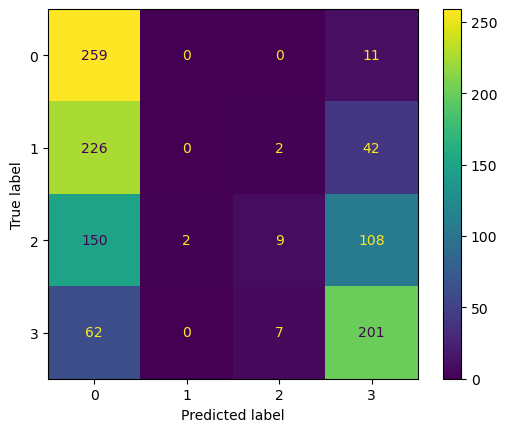

In [17]:
# # create baseline logistic regression to see if the target is in the dat

# X = census_df.drop(columns = ['SVI_Rank', 'target'])
# y = census_df['target']

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 42)

# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler

# ss = StandardScaler()
# X_train_scaled = ss.fit_transform(X_train)
# X_test_scaled = ss.transform(X_test)

# lr = LogisticRegression(random_state = 42, max_iter = 500, penalty = 'none')
# lr.fit(X_train, y_train)

# from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix

# plot_confusion_matrix(lr, X_test_scaled, y_test)
# lr.score(X_test_scaled, y_test)


Unfortunately, classifying social vulnerability is not going to work becuase there is not target variable included in the dataset.

## New Idea!!!!!

Using county level COVID-19 data from the CDC, I am going to attempt to merge community COVID-19 levels onto the SVI to try to see if there is a predictive relationship between social vulnerability and COVID-19

In [377]:
covid_df = pd.read_csv('data/United_States_COVID-19_Community_Levels_by_County.csv')

In [378]:
#isolate NY counties
ny_covid_df = covid_df[covid_df['state'] == 'New York']

In [379]:
ny_covid_df = ny_covid_df[ny_covid_df['date_updated'] == '2022-02-24' ]

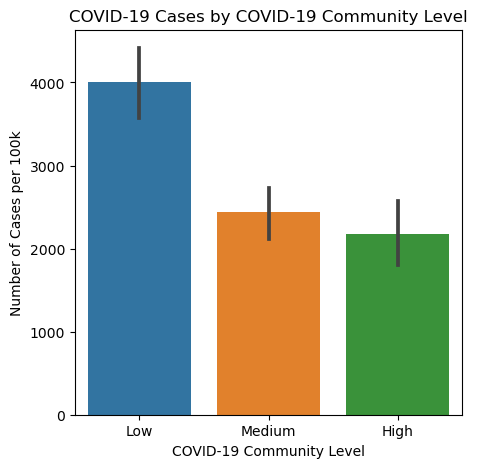

<Figure size 640x480 with 0 Axes>

In [386]:
fig, ax = plt.subplots(figsize = (5,5))
sns.barplot(x = 'covid-19_community_level', y = 'covid_cases_per_100k', data = ny_covid_df,
            estimator = np.sum, order = ['Low', 'Medium', 'High'])
ax.set_xlabel('COVID-19 Community Level')
ax.set_ylabel('Number of Cases per 100k')
ax.set_title('COVID-19 Cases by COVID-19 Community Level')
plt.show()
plt.savefig('covidcasesdistro.png');

In [280]:
#dataset includes assessments for each county at multiple different points in time. The SVI data is dated 
# from 2020 so I will use the earliest date to align as best as possible  
ny_covid_df['date_updated'].sort_values(ascending=True)
ny_covid_df = ny_covid_df[ny_covid_df['date_updated'] == '2022-02-24' ]
ny_county_covid = ny_covid_df[['county', 'covid-19_community_level']]
ny_county_covid['county'] = ny_county_covid['county'].str.split().str[0]
ny_county_covid['county'].replace(['New', 'St.'], ['New York', 'St. Lawrence'], inplace = True)
ny_county_covid.rename(columns = {'county': 'COUNTY'}, inplace = True)

# ny_county_covid.set_index('county', drop = True, inplace = True)
# county_covid_dict = ny_county_covid.to_dict()['covid-19_community_level']
# county_covid_dict


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [282]:
#Merge the covid data onto the census data

joint_df = census_df.merge(ny_county_covid, how = 'left', on = 'COUNTY')
joint_df = joint_df.rename(columns = {'covid-19_community_level': 'target'})
joint_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5260 entries, 0 to 5259
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   COUNTY     5260 non-null   object 
 1   AREA_SQMI  5260 non-null   float64
 2   E_TOTPOP   5260 non-null   int64  
 3   E_HU       5260 non-null   int64  
 4   E_HH       5260 non-null   int64  
 5   E_POV150   5260 non-null   int64  
 6   E_UNEMP    5260 non-null   int64  
 7   E_HBURD    5260 non-null   int64  
 8   E_NOHSDP   5260 non-null   int64  
 9   E_UNINSUR  5260 non-null   int64  
 10  E_AGE65    5260 non-null   int64  
 11  E_AGE17    5260 non-null   int64  
 12  E_DISABL   5260 non-null   int64  
 13  E_SNGPNT   5260 non-null   int64  
 14  E_LIMENG   5260 non-null   int64  
 15  E_MINRTY   5260 non-null   int64  
 16  E_MUNIT    5260 non-null   int64  
 17  E_MOBILE   5260 non-null   int64  
 18  E_CROWD    5260 non-null   int64  
 19  E_NOVEH    5260 non-null   int64  
 20  E_GROUPQ

In [283]:
joint_df = joint_df.drop(columns = ['SVI_Rank', 'COUNTY'])
joint_df['target'].value_counts()

Low       3921
Medium    1054
High       285
Name: target, dtype: int64

In [284]:
modeless_accuracy = (3921/(3921+1054+285))*100
print('The accuracy for a modeless classifier would be: {}%'.format(modeless_accuracy))

The accuracy for a modeless classifier would be: 74.54372623574145%


In [388]:
percent_high = (285/(3921+1054+285))*100
percent_high

5.418250950570342

## EDA

From the data dictionary associated with the SVI census data, I know that missing values in the data are marked with a value of 999. I will find and replace them with NaN so they can be imputed as part of the pipeline later on.

In [285]:
joint_df.replace(999, np.nan, inplace = True )
joint_df['target'] = joint_df['target'].map({'Low':0, 'Medium': 1, 'High': 2})


In [286]:
joint_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5260 entries, 0 to 5259
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AREA_SQMI  5260 non-null   float64
 1   E_TOTPOP   5260 non-null   int64  
 2   E_HU       5259 non-null   float64
 3   E_HH       5258 non-null   float64
 4   E_POV150   5258 non-null   float64
 5   E_UNEMP    5260 non-null   int64  
 6   E_HBURD    5260 non-null   int64  
 7   E_NOHSDP   5259 non-null   float64
 8   E_UNINSUR  5260 non-null   int64  
 9   E_AGE65    5258 non-null   float64
 10  E_AGE17    5258 non-null   float64
 11  E_DISABL   5260 non-null   int64  
 12  E_SNGPNT   5260 non-null   int64  
 13  E_LIMENG   5259 non-null   float64
 14  E_MINRTY   5258 non-null   float64
 15  E_MUNIT    5258 non-null   float64
 16  E_MOBILE   5260 non-null   int64  
 17  E_CROWD    5260 non-null   int64  
 18  E_NOVEH    5258 non-null   float64
 19  E_GROUPQ   5260 non-null   int64  
 20  E_NOINT 

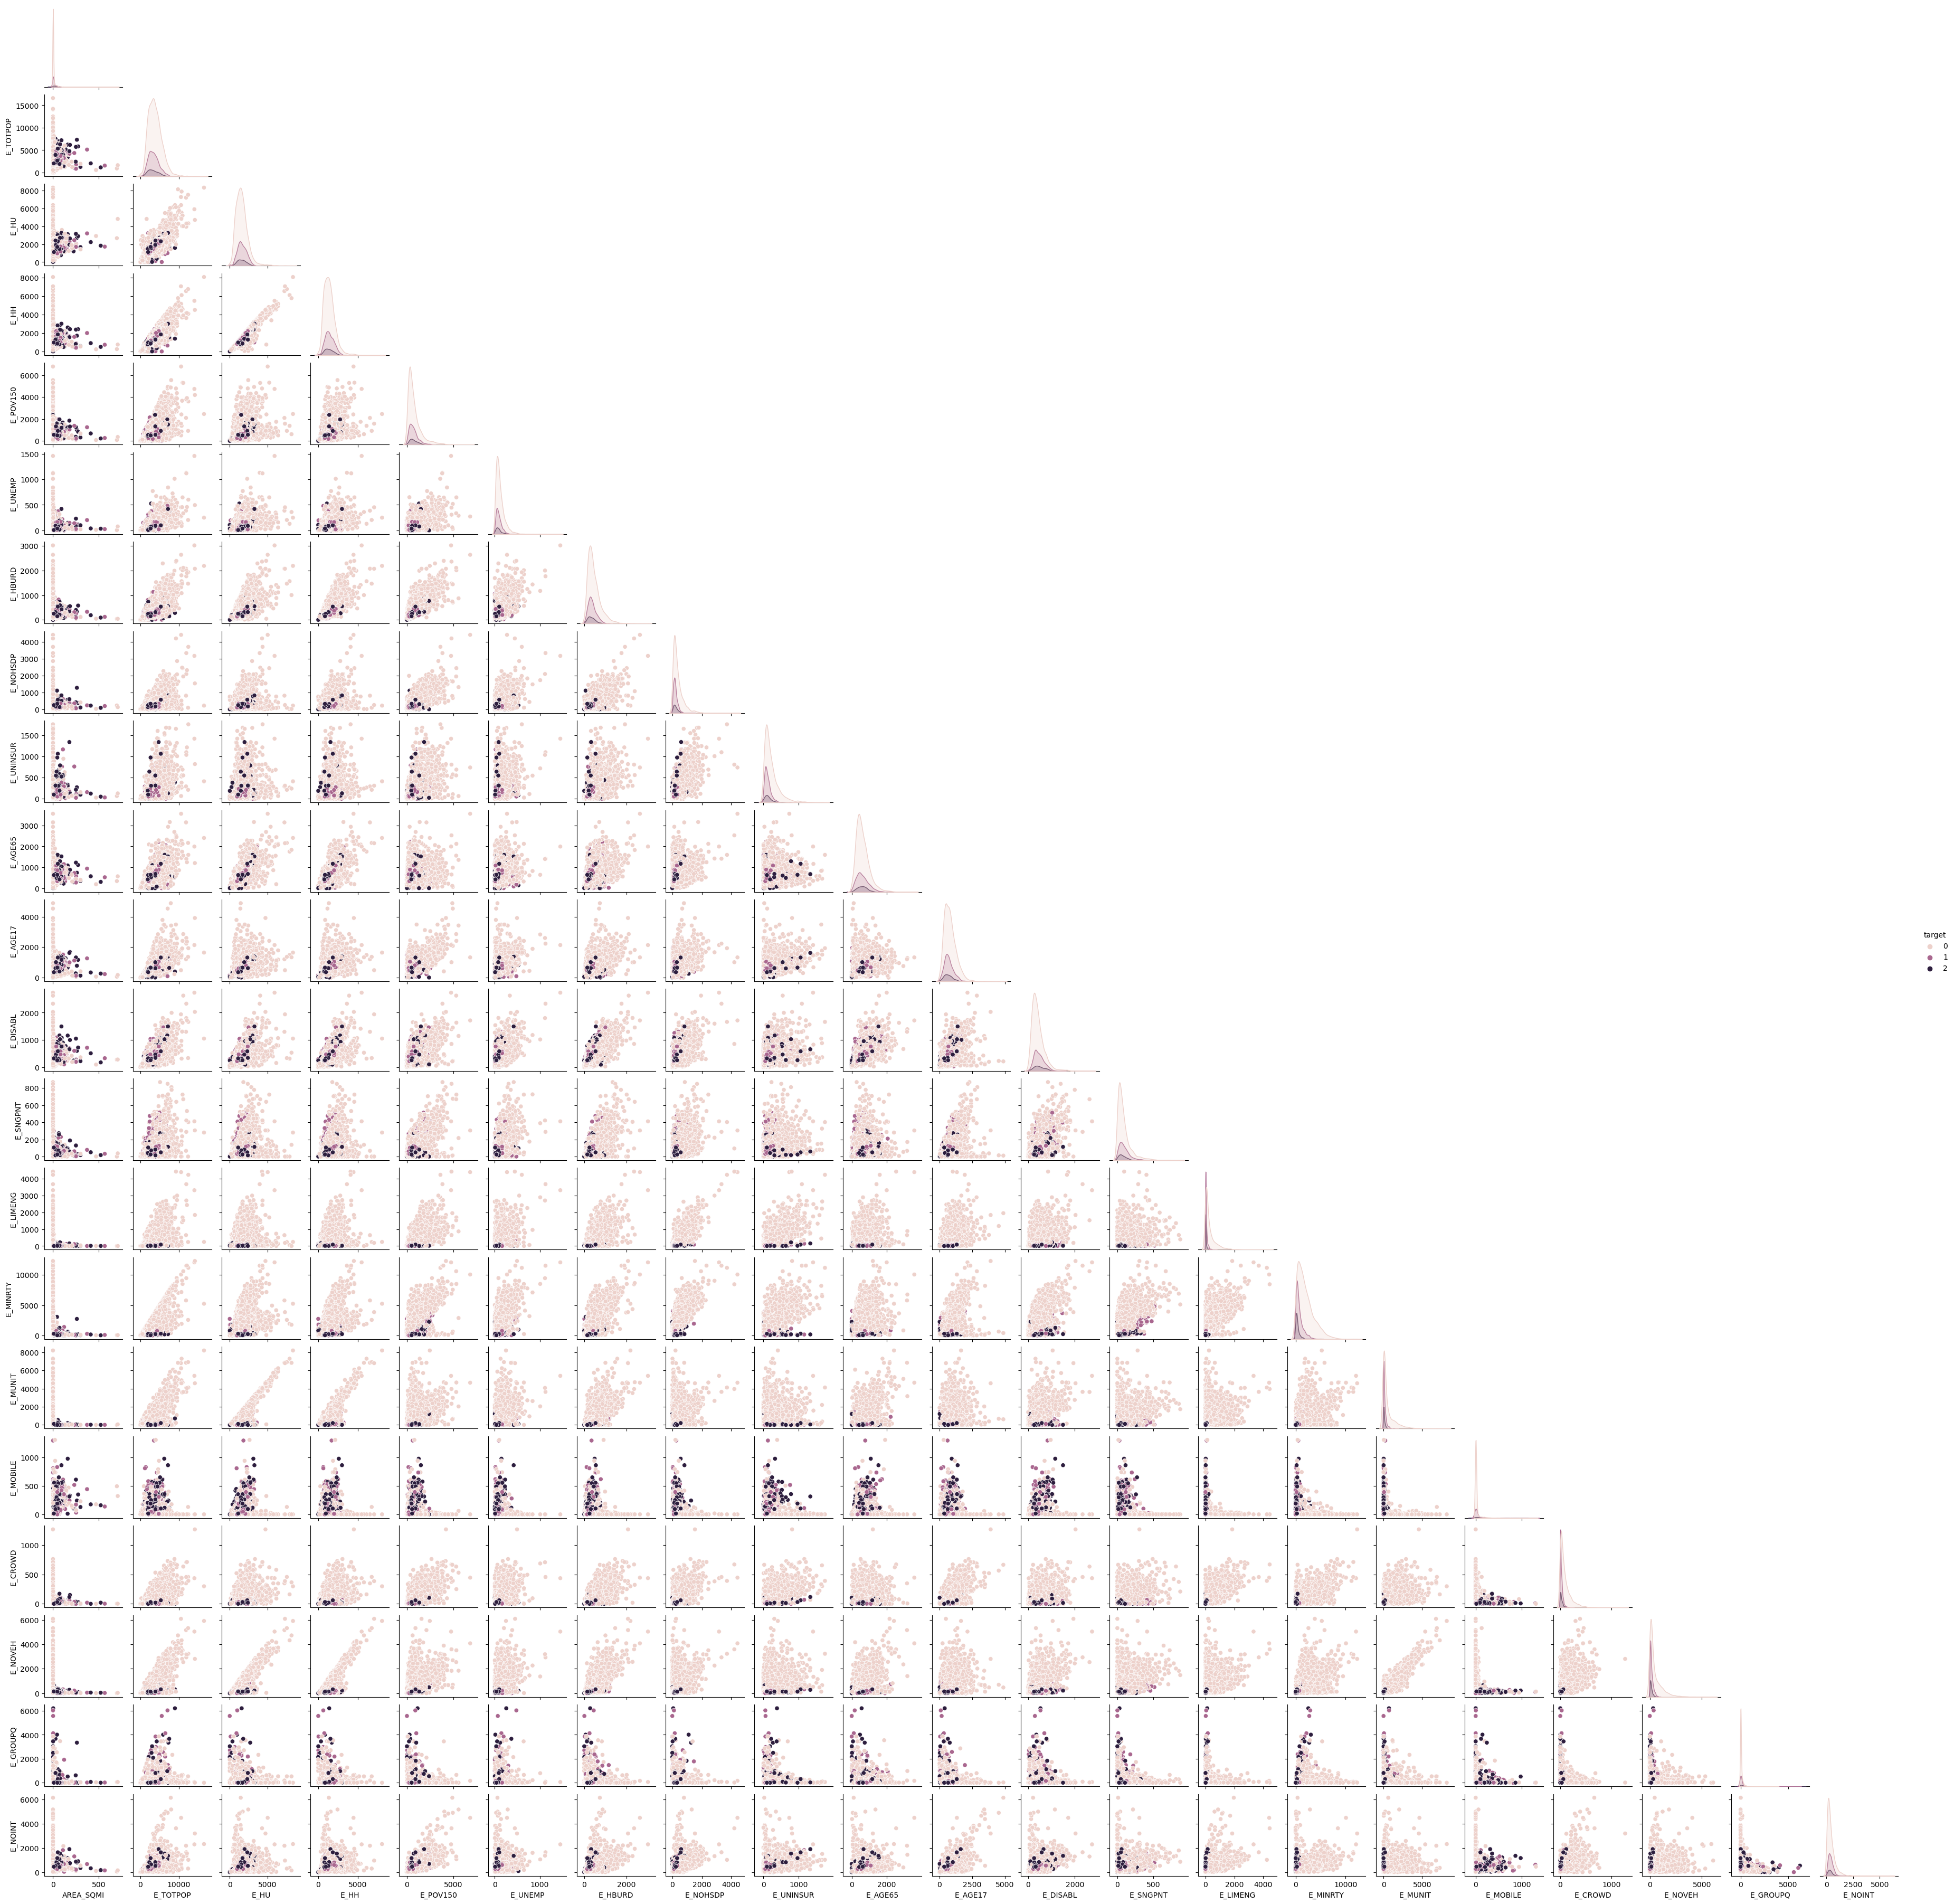

In [433]:
sns.pairplot(hue = 'target', data = joint_df, height = 1.75, corner = True)

Almost all of the independent variables are multi-colinear which makes sense because they are all population estimates. Use of regularization is going to be important here. The target population is not normally distributed, so if I want to use any Bayesian models it will require a transformation. 

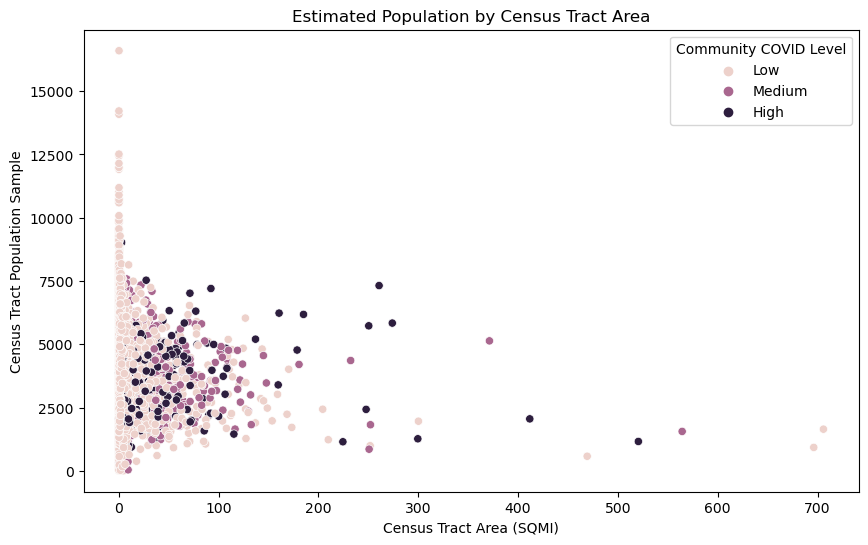

In [555]:
fig, ax = plt.subplots(figsize = (10,6))
sns.scatterplot(x = 'AREA_SQMI', y = 'E_TOTPOP', hue = 'target', data = joint_df, legend = 'brief')
ax.set_xlabel('Census Tract Area (SQMI)')
ax.set_ylabel('Census Tract Population Sample')
handles, labels = ax.get_legend_handles_labels()
label_dict = {0: 'Low', 1: 'Medium', 2: 'High'}
new_labels = [label_dict.get(int(label), label) for label in labels]
ax.legend(handles=handles, labels=new_labels, title='Community COVID Level')
ax.set_title('Estimated Population by Census Tract Area')
plt.show()

The population of NY is densely populated in small areas. 

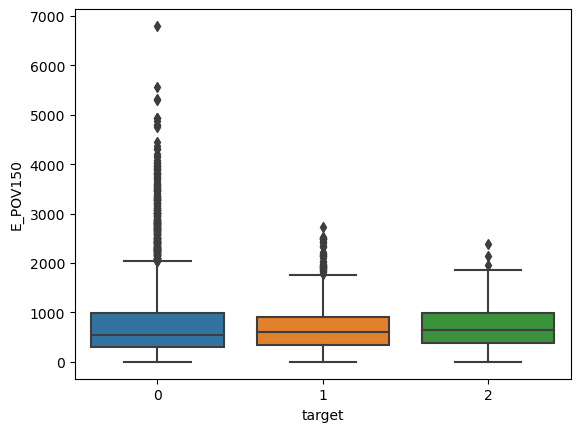

In [339]:
fig, ax = plt.subplots()

sns.boxplot(x = 'target' , y = 'E_POV150', data = joint_df)

plt.show()

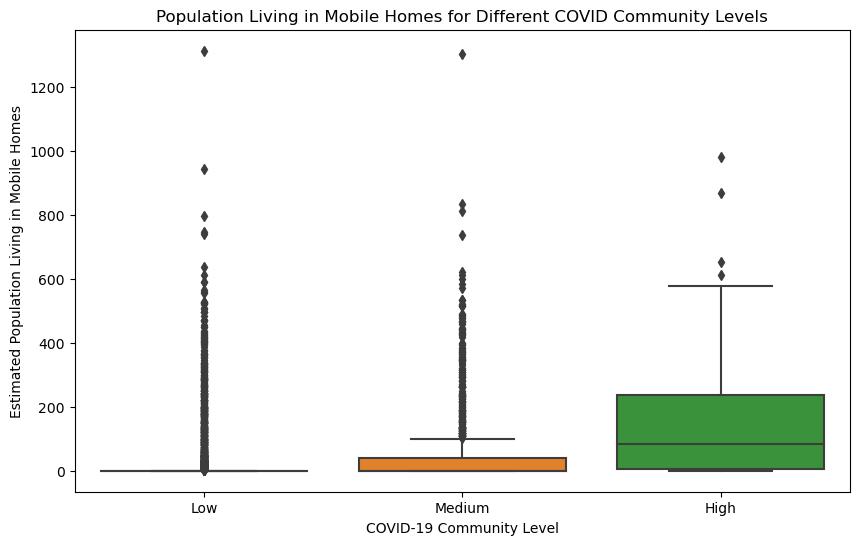

In [486]:
fig, ax = plt.subplots(figsize = (10,6))

sns.boxplot(x = 'target' , y = 'E_MOBILE', data = joint_df)
ax.set_xticklabels(['Low', 'Medium', 'High'])
ax.set_xlabel('COVID-19 Community Level')
ax.set_ylabel('Estimated Population Living in Mobile Homes')
ax.set_title('Population Living in Mobile Homes for Different COVID Community Levels')
plt.show()


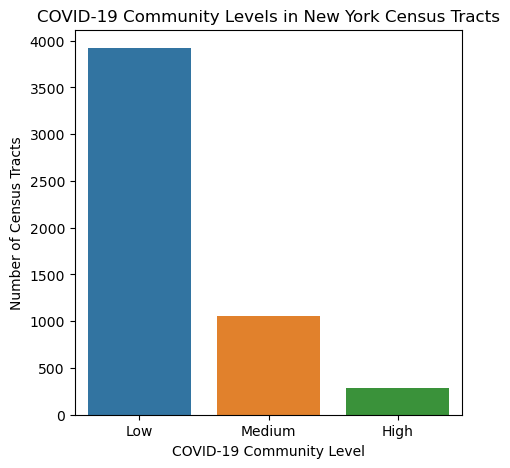

<Figure size 640x480 with 0 Axes>

In [365]:
fig, ax = plt.subplots(figsize = (5,5))
sns.countplot(x = 'target', data = joint_df)
ax.set_xticklabels(['Low', 'Medium', 'High'])
ax.set_xlabel('COVID-19 Community Level')
ax.set_ylabel('Number of Census Tracts')
ax.set_title('COVID-19 Community Levels in New York Census Tracts')
plt.show()
plt.savefig('targetdistro.png');

## Train-Test Split

In [389]:
X = joint_df.drop(columns = 'target')
y = joint_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = .25, random_state = 42) 

## Baseline Model - Standard Logistic Regression 

In [390]:
#set up pipeline
steps = [('imputer', SimpleImputer(strategy="median")), ('std_scaler', StandardScaler()),
        ('lr', LogisticRegression(solver = 'saga', random_state=42))]

model_pipe = Pipeline(steps)
model_pipe

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('std_scaler', StandardScaler()),
                ('lr', LogisticRegression(random_state=42, solver='saga'))])

In [391]:
#create custom cross validation function for future use 

def cross_validation(X_train, y_train, estimator, num_split = 5):
    
    X_train = X_train.values
    y_train = y_train.values
    
    score_train_list = []
    score_val_list = []
    
    for train_index, valid_index in KFold(n_splits = num_split).split(X_train):
        
        # train and validation splitting 
        X_train_fold, X_val_fold = X_train[train_index], X_train[valid_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[valid_index]

        estimator.fit(X_train_fold, y_train_fold)
        
        # now how did we do?
        accuracy_train = estimator.score(X_train_fold, y_train_fold)
        accuracy_val = estimator.score(X_val_fold, y_val_fold)
        score_val_list.append(accuracy_val)
        score_train_list.append(accuracy_train)
    
    return {'train': np.mean(score_train_list), 'validation': np.mean(score_val_list)}

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


{'train': 0.827122940430925, 'validation': 0.8243346007604563}
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       980
           1       0.66      0.59      0.62       264
           2       0.38      0.11      0.17        71

    accuracy                           0.82      1315
   macro avg       0.64      0.55      0.57      1315
weighted avg       0.80      0.82      0.81      1315



The max_iter was reached which means the coef_ did not converge
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but SimpleImputer was fitted without feature names
X has feature names, but SimpleImputer was fitted without feature names


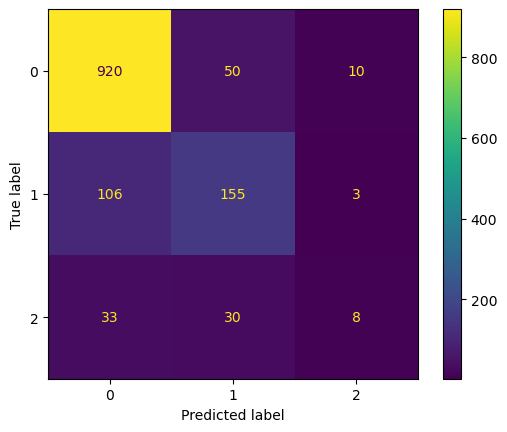

In [392]:
#assess baseline performance 

print(cross_validation(X_train, y_train, model_pipe))
plot_confusion_matrix(model_pipe, X_test, y_test)
y_pred = model_pipe.predict(X_test)
print(classification_report(y_test, y_pred))

### Observations

* Train and validation accuracy are very close together so we know that the model is not overfitting
* High accuracy score is misleading as the model is not very accurate in predicting classes 1 and 2
* Imbalance for class 2 in the dataset is an issue, will need to use some sort of oversampling technique
* Model was not able to converge on the error minimizing point. Need to adjust hyperparameters 


## Model 2: Logistic Regression with SMOTE  

In [634]:
steps_2 = [('imputer', SimpleImputer(strategy="median")),
           ('sampler', SMOTE(sampling_strategy = 'minority', random_state =42)),
           ('std_scaler', StandardScaler()),
        ('lr', LogisticRegression(solver = 'saga', random_state=42))]

sm_model = Pipeline(steps_2)
sm_model

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('sampler',
                 SMOTE(random_state=42, sampling_strategy='minority')),
                ('std_scaler', StandardScaler()),
                ('lr', LogisticRegression(random_state=42, solver='saga'))])

In [293]:
#checking that the imputer works 

# from imblearn.over_sampling import SMOTE
# smote = SMOTE(sampling_strategy = 'not majority', random_state = 42)
# imputer = SimpleImputer(strategy = 'median')
# X_train_sm = imputer.fit_transform(X_train)
# X_oversample, y_oversample = smote.fit_resample(X_train_sm, y_train)

# y_oversample.value_counts()

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


{'train': 0.7520912547528515, 'validation': 0.7477820025348543}
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       980
           1       0.84      0.25      0.38       264
           2       0.19      0.89      0.32        71

    accuracy                           0.75      1315
   macro avg       0.66      0.67      0.53      1315
weighted avg       0.88      0.75      0.77      1315



The max_iter was reached which means the coef_ did not converge
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but SimpleImputer was fitted without feature names
X has feature names, but SimpleImputer was fitted without feature names


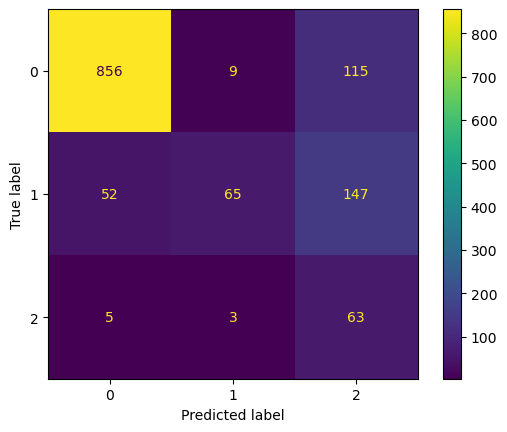

In [636]:
#assess model_2 performance 

print(cross_validation(X_train, y_train, sm_model))
plot_confusion_matrix(sm_model, X_test, y_test)
y_pred = sm_model.predict(X_test)
print(classification_report(y_test, y_pred))

In [563]:
np.unique(y_test)

array([0, 1, 2])

### Observations

* Lose a bit of accuracy on the train and validation scores, but the model improves recall on the high COVID level areas which is the priority target in this model. This comes with many false positives, but in this case my hypothesis is that it is better to have false positives and allocate resources, then be unprepared and there be risk to human life  
* Tuning the hyperparameters to allow the model to actually converge could help improve the scores and accuracy 

## Model 3: Logistic Regression with SMOTE and GridSearch 

In [295]:
LogisticRegression()

LogisticRegression()

In [335]:
c_values = [10 ** i for i in range(-3, 4)]
tol_values = [1, 1e-1, 1e-2, 1e-3, 1e-4]
max_iter_values = np.arange(500, 20000, 500)

params = {'lr__penalty': ['l1', 'l2'],
          'lr__C': c_values,
         'lr__max_iter': max_iter_values,
         'lr__tol': tol_values}

cv = GridSearchCV(estimator = sm_model, param_grid = params, cv = 5, n_jobs = -1)
cv.fit(X_train, y_train)
best_sm_model = cv.best_estimator_

/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/s

{'train': 0.755576679340938, 'validation': 0.7513307984790873}
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       980
           1       0.84      0.27      0.40       264
           2       0.19      0.86      0.31        71

    accuracy                           0.75      1315
   macro avg       0.66      0.67      0.54      1315
weighted avg       0.88      0.75      0.78      1315



Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but SimpleImputer was fitted without feature names
X has feature names, but SimpleImputer was fitted without feature names


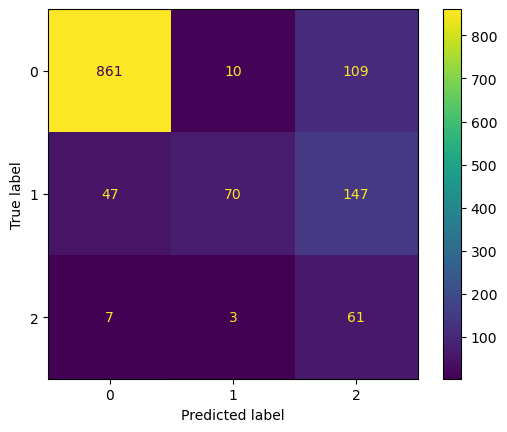

In [633]:
print(cross_validation(X_train, y_train, best_sm_model))
plot_confusion_matrix(best_sm_model, X_test, y_test)
y_pred = best_sm_model.predict(X_test)
print(classification_report(y_test, y_pred))

### Observations 

* The resulting model is slightly less accurate than the original SMOTE model. Will move on to try different modeling techniques 

## Model 4: Decision Tree

In [393]:
steps_4 = [('imputer', SimpleImputer(strategy="median")),
        ('sampler', SMOTE(sampling_strategy = 'minority', random_state =42)),   
        ('dt', DecisionTreeClassifier(max_depth = 10, random_state = 42))]

dt_model = Pipeline(steps_4)
dt_model.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('sampler',
                 SMOTE(random_state=42, sampling_strategy='minority')),
                ('dt', DecisionTreeClassifier(max_depth=10, random_state=42))])

{'train': 0.8875792141951837, 'validation': 0.7237008871989861}
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       980
           1       0.53      0.35      0.42       264
           2       0.18      0.58      0.28        71

    accuracy                           0.71      1315
   macro avg       0.53      0.58      0.51      1315
weighted avg       0.77      0.71      0.73      1315



Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but SimpleImputer was fitted without feature names
X has feature names, but SimpleImputer was fitted without feature names


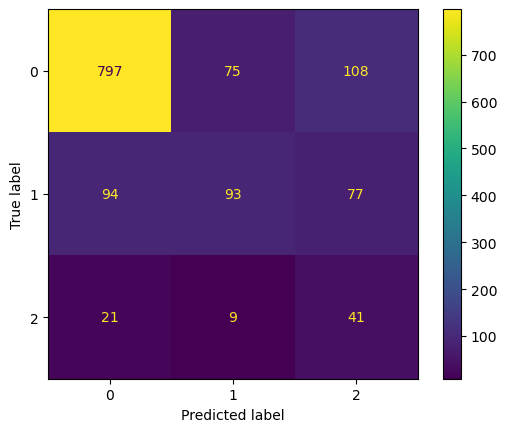

In [394]:
print(cross_validation(X_train, y_train, dt_model))
plot_confusion_matrix(dt_model, X_test, y_test)
y_pred = dt_model.predict(X_test)
print(classification_report(y_test, y_pred))

### Observations

* highest training score yet, but it is clearly overfitting 
* next step: tune the hyperparameters to improve validation score 

## Model 5: Tuned Decision Tree

In [ ]:
DecisionTreeClassifier()

In [319]:
max_depth_values = range(2,11)
min_sample_leaf_values = range(2,6)
max_feature_values = range(2,22)
criterion_values = ['gini', 'entropy']
splitter_values = ['best', 'random']
class_weight_values = ['balanced', None]

params = {'dt__max_depth': max_depth_values,
           'dt__min_samples_leaf': min_sample_leaf_values,
          'dt__max_features': max_feature_values,
          'dt__criterion': criterion_values,
         'dt__splitter': splitter_values,
         'dt__class_weight': class_weight_values}

dt_cv = GridSearchCV(estimator = dt_model, param_grid = params, cv = 5, n_jobs = -1)
dt_cv.fit(X_train, y_train)
best_dt_model = dt_cv.best_estimator_

In [321]:
print(cross_validation(X_train, y_train, best_dt_model))

{'train': 0.852661596958175, 'validation': 0.7226869455006337}


{'train': 0.852661596958175, 'validation': 0.7226869455006337}
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       980
           1       0.49      0.55      0.52       264
           2       0.23      0.52      0.32        71

    accuracy                           0.73      1315
   macro avg       0.54      0.62      0.56      1315
weighted avg       0.79      0.73      0.75      1315



Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but SimpleImputer was fitted without feature names
X has feature names, but SimpleImputer was fitted without feature names


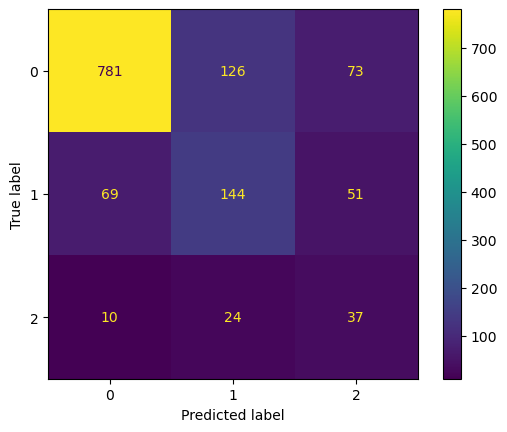

In [602]:
print(cross_validation(X_train, y_train, best_dt_model))
plot_confusion_matrix(best_dt_model, X_test, y_test)
y_pred = best_dt_model.predict(X_test)
print(classification_report(y_test, y_pred))

### Observations
* improvement over the baseline and logistic regression train scores, but is still overfitted. 
* reasonable next step would be to try random forest and XGBoost to try to further improve performance while reducing overfitting 

## Random Forest

In [675]:
rf_model = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('sampler', SMOTE(sampling_strategy = 'minority', random_state =42)),
    ('std_scaler', StandardScaler()),
    ('rf', RandomForestClassifier(n_estimators=150, random_state = 42))])

rf_model.fit(X_train, y_train)


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('sampler',
                 SMOTE(random_state=42, sampling_strategy='minority')),
                ('std_scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(n_estimators=150, random_state=42))])

{'train': 1.0, 'validation': 0.7782002534854247}
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       980
           1       0.71      0.38      0.49       264
           2       0.25      0.61      0.36        71

    accuracy                           0.78      1315
   macro avg       0.61      0.63      0.58      1315
weighted avg       0.81      0.78      0.78      1315



Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but SimpleImputer was fitted without feature names
X has feature names, but SimpleImputer was fitted without feature names


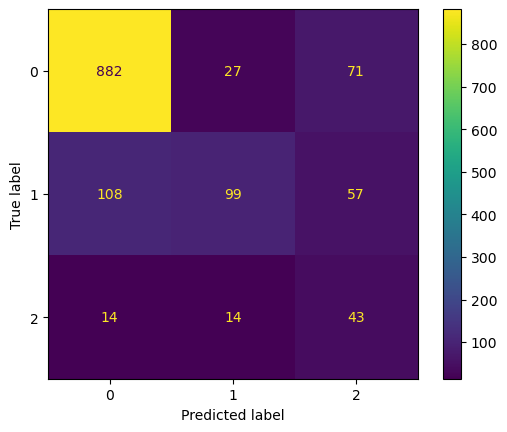

In [677]:
print(cross_validation(X_train, y_train, rf_model))
plot_confusion_matrix(rf_model, X_test, y_test)
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

RF model is still very overfitted, but improved the validation score over the decision tree and is only second to the baseline logistic model 

## Tuned Random Forest

In [329]:

params = {'rf__n_estimators': [10, 50, 100, 200, 500],
          'rf__max_depth': [5, 10, 20, None],
          'rf__min_samples_split': [2, 5, 10],
          'rf__min_samples_leaf': [1, 2, 4],
          'rf__max_features': ['auto', 'sqrt', 'log2', None]}

rf_cv = GridSearchCV(estimator = rf_model, param_grid = params, cv = 5, n_jobs = -1)
rf_cv.fit(X_train, y_train)
best_rf_model = rf_cv.best_estimator_

In [331]:
best_rf_model

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('sampler',
                 SMOTE(random_state=42, sampling_strategy='not majority')),
                ('std_scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(max_depth=20, min_samples_split=5,
                                        n_estimators=500, random_state=42))])

In [332]:
print(cross_validation(X_train, y_train, best_rf_model))

{'train': 1.0, 'validation': 0.7964512040557669}


In [610]:
print(best_rf_model.get_params())

{'memory': None, 'steps': [('imputer', SimpleImputer(strategy='median')), ('sampler', SMOTE(random_state=42, sampling_strategy='not majority')), ('std_scaler', StandardScaler()), ('rf', RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=500,
                       random_state=42))], 'verbose': False, 'imputer': SimpleImputer(strategy='median'), 'sampler': SMOTE(random_state=42, sampling_strategy='not majority'), 'std_scaler': StandardScaler(), 'rf': RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=500,
                       random_state=42), 'imputer__add_indicator': False, 'imputer__copy': True, 'imputer__fill_value': None, 'imputer__missing_values': nan, 'imputer__strategy': 'median', 'imputer__verbose': 0, 'sampler__k_neighbors': 5, 'sampler__n_jobs': None, 'sampler__random_state': 42, 'sampler__sampling_strategy': 'not majority', 'std_scaler__copy': True, 'std_scaler__with_mean': True, 'std_scaler__with_std': True, 'rf__bootstrap': True, 

In [626]:
best_rf_model.set_params(rf__max_depth = 6)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('sampler',
                 SMOTE(random_state=42, sampling_strategy='not majority')),
                ('std_scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(max_depth=6, min_samples_split=5,
                                        n_estimators=500, random_state=42))])

{'train': 0.7740177439797211, 'validation': 0.7328263624841572}
              precision    recall  f1-score   support

           0       0.95      0.75      0.84       980
           1       0.49      0.64      0.55       264
           2       0.22      0.63      0.33        71

    accuracy                           0.72      1315
   macro avg       0.55      0.67      0.57      1315
weighted avg       0.82      0.72      0.75      1315



Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but SimpleImputer was fitted without feature names
X has feature names, but SimpleImputer was fitted without feature names


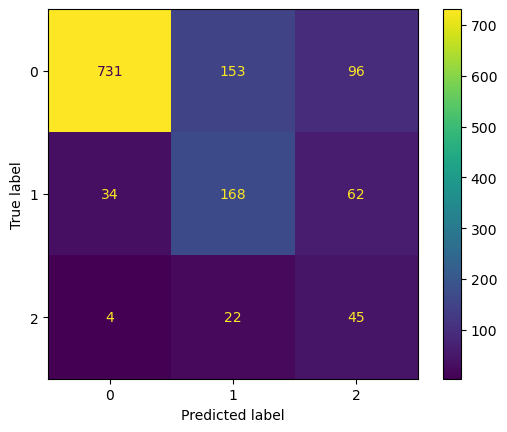

In [627]:
print(cross_validation(X_train, y_train, best_rf_model))
plot_confusion_matrix(best_rf_model, X_test, y_test)
y_pred = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

### Observations

* still overfitting, but the validation score has improved over the previous versions

## Gradient Boosting 

In [49]:
gb = XGBClassifier()

In [678]:
gb_model = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('sampler', SMOTE(sampling_strategy = 'minority', random_state =42)),
    ('std_scaler', StandardScaler()),
    ('gb', XGBClassifier(random_state = 42))])

gb_model.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('sampler',
                 SMOTE(random_state=42, sampling_strategy='minority')),
                ('std_scaler', StandardScaler()),
                ('gb',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                            

{'train': 1.0, 'validation': 0.802281368821293}
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       980
           1       0.65      0.45      0.53       264
           2       0.26      0.55      0.36        71

    accuracy                           0.79      1315
   macro avg       0.60      0.63      0.59      1315
weighted avg       0.81      0.79      0.79      1315



Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but SimpleImputer was fitted without feature names
X has feature names, but SimpleImputer was fitted without feature names


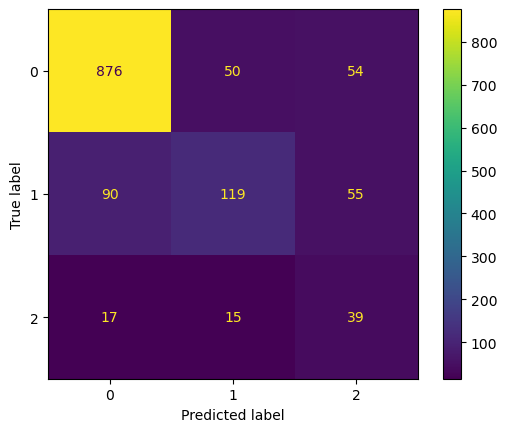

In [680]:
print(cross_validation(X_train, y_train, gb_model))
plot_confusion_matrix(gb_model, X_test, y_test)
y_pred = gb_model.predict(X_test)
print(classification_report(y_test, y_pred))

In [53]:
gb_model.score(X_test, y_test)

/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


0.8139362490733877

### Observations

* overfitted, but better validation score than any of the trees we have tried thus far

## Tuned Gradient Boost Model

In [399]:
params = {'gb__n_estimators': [50, 100, 200, 300, 400, 500],
          'gb__max_depth': [1, 2, 3, 4, 5],
          'gb__learning_rate': [.01, .03, .05, .07, .1],
          'gb__subsample': [0.5, 0.75, 1]}

gb_cv = GridSearchCV(estimator = gb_model, param_grid = params, cv = 5, n_jobs = -1)
gb_cv.fit(X_train, y_train)
best_gb_model = gb_cv.best_estimator_

In [400]:
best_gb_model

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('sampler',
                 SMOTE(random_state=42, sampling_strategy='minority')),
                ('std_scaler', StandardScaler()),
                ('gb',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.1,
                               max_bin=256, max_cat_threshold=64,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=5, max_leaves=0, min_child_weight=1,
                

In [401]:
print(cross_validation(X_train, y_train, best_gb_model))

{'train': 1.0, 'validation': 0.8119138149556401}


In [402]:
subsample = best_gb_model.named_steps['gb'].get_params()['subsample']
subsample

1

## Try to reduce overfitting 

In [631]:
best_gb_model_overfit = best_gb_model.set_params(gb__max_depth = 5)
best_gb_model

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('sampler',
                 SMOTE(random_state=42, sampling_strategy='minority')),
                ('std_scaler', StandardScaler()),
                ('gb',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.1,
                               max_bin=256, max_cat_threshold=64,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=5, max_leaves=0, min_child_weight=1,
                

{'train': 1.0, 'validation': 0.8119138149556401}
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       980
           1       0.65      0.46      0.54       264
           2       0.25      0.48      0.33        71

    accuracy                           0.79      1315
   macro avg       0.60      0.61      0.59      1315
weighted avg       0.81      0.79      0.79      1315



Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but SimpleImputer was fitted without feature names
X has feature names, but SimpleImputer was fitted without feature names


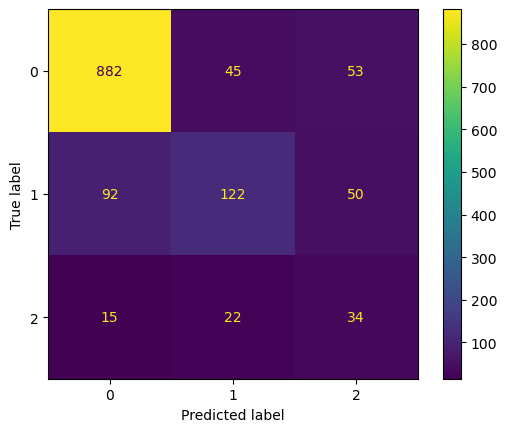

In [681]:
best_gb_model_overfit.fit(X_train, y_train)
print(cross_validation(X_train, y_train, best_gb_model_overfit))
plot_confusion_matrix(best_gb_model_overfit, X_test, y_test)
y_pred = best_gb_model.predict(X_test)
print(classification_report(y_test, y_pred))

## Try KNN!

In [404]:
knn_model = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('sampler', SMOTE(sampling_strategy = 'minority', random_state =42)),
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_jobs = -1) )])

knn_model

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('sampler',
                 SMOTE(random_state=42, sampling_strategy='minority')),
                ('std_scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_jobs=-1))])

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepd

{'train': 0.814638783269962, 'validation': 0.7434727503168569}


Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
X has feature names, but SimpleImputer was fitted without feature names
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.


              precision    recall  f1-score   support

           0       0.93      0.83      0.88       980
           1       0.60      0.36      0.45       264
           2       0.17      0.66      0.27        71

    accuracy                           0.73      1315
   macro avg       0.57      0.62      0.53      1315
weighted avg       0.82      0.73      0.76      1315



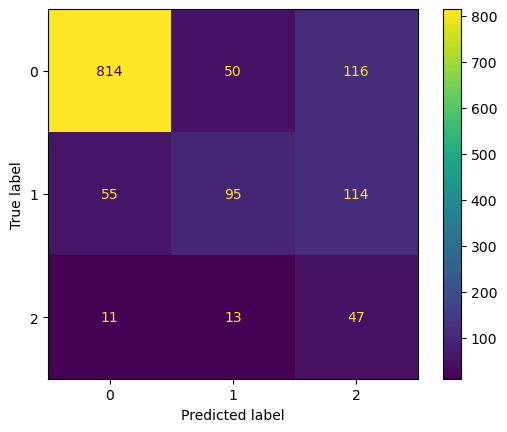

In [683]:
print(cross_validation(X_train, y_train, knn_model))
plot_confusion_matrix(knn_model, X_test, y_test)
y_pred = knn_model.predict(X_test)
print(classification_report(y_test, y_pred))

## Tuning KNN

In [406]:
params = {'knn__weights': ['uniform', 'distance'],
          'knn__n_neighbors': range(5, 21),
          'knn__leaf_size': [5, 10, 20, 30, 40, 50]}

knn_cv = GridSearchCV(estimator = knn_model, param_grid = params, cv = 5, n_jobs = -1)
knn_cv.fit(X_train, y_train)
best_knn_model = knn_cv.best_estimator_

/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be 

/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be 

/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be 

/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be 

/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be 

/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be 

/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be 

/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be 

/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be 

/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be 

/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be 

/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be 

In [407]:
best_knn_model.score(X_test, y_test)

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.


0.7315589353612167

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepd

{'train': 0.814638783269962, 'validation': 0.7434727503168569}


Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
X has feature names, but SimpleImputer was fitted without feature names
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.


              precision    recall  f1-score   support

           0       0.93      0.83      0.88       980
           1       0.60      0.36      0.45       264
           2       0.17      0.66      0.27        71

    accuracy                           0.73      1315
   macro avg       0.57      0.62      0.53      1315
weighted avg       0.82      0.73      0.76      1315



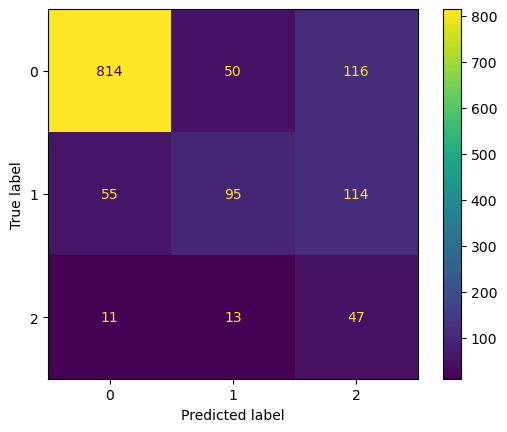

In [682]:
best_knn_model.fit(X_train, y_train)
print(cross_validation(X_train, y_train, best_knn_model))
plot_confusion_matrix(best_knn_model, X_test, y_test)
y_pred = best_knn_model.predict(X_test)
print(classification_report(y_test, y_pred))

KNN overfits and had a lower validation score than either logistic regression or XGBoost 

## Quadratic Discriminent Analysis 

In [412]:
quad_model = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('sampler', SMOTE(sampling_strategy = 'minority', random_state =42)),
    ('quan_scaler', QuantileTransformer()),
    ('quad', QuadraticDiscriminantAnalysis())])

quad_model

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('sampler',
                 SMOTE(random_state=42, sampling_strategy='minority')),
                ('quan_scaler', QuantileTransformer()),
                ('quad', QuadraticDiscriminantAnalysis())])

In [409]:
print(cross_validation(X_train, y_train, quad_model))

{'train': 0.8021546261089988, 'validation': 0.7743979721166034}


## Multinomial Naive Bayes

In [430]:
from sklearn.naive_bayes import ComplementNB

bayes = ComplementNB()

bayes_model = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('sampler', SMOTE(sampling_strategy = 'minority', random_state =42)),
    ('quan_scaler', QuantileTransformer()),
    ('bayes', ComplementNB())])

bayes_model

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('sampler',
                 SMOTE(random_state=42, sampling_strategy='minority')),
                ('quan_scaler', QuantileTransformer()),
                ('bayes', ComplementNB())])

{'train': 0.6662864385297845, 'validation': 0.6664131812420786}
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       980
           1       0.80      0.02      0.03       264
           2       0.16      0.80      0.27        71

    accuracy                           0.66      1315
   macro avg       0.60      0.55      0.38      1315
weighted avg       0.79      0.66      0.64      1315



Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but SimpleImputer was fitted without feature names
X has feature names, but SimpleImputer was fitted without feature names


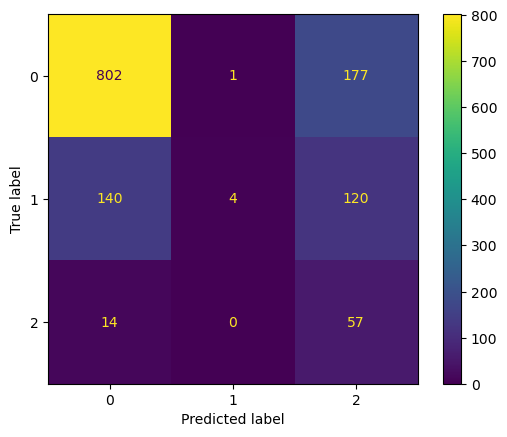

In [431]:
bayes_model.fit(X_train, y_train)
print(cross_validation(X_train, y_train, bayes_model))
plot_confusion_matrix(bayes_model, X_test, y_test)
y_pred = bayes_model.predict(X_test)
print(classification_report(y_test, y_pred))

## Stacking Models

Going to attempt to create a stacked model using my best models thus far. I want to try combine models that are better at identifying different types of errors. For my first stacked model, I will try combining my tuned logistic regression and my tuned GB models

In [644]:
from sklearn.ensemble import StackingClassifier

estimators = [('lr', sm_model),
             ('gb', best_gb_model_overfit)]

sr = StackingClassifier(estimators)

lr_gb_model = sr.fit(X_train, y_train)
print(cross_validation(X_train, y_train, lr_gb_model))

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

{'train': 0.9282636248415717, 'validation': 0.8362484157160963}


              precision    recall  f1-score   support

           0       0.90      0.93      0.91       980
           1       0.67      0.67      0.67       264
           2       0.41      0.23      0.29        71

    accuracy                           0.84      1315
   macro avg       0.66      0.61      0.62      1315
weighted avg       0.83      0.84      0.83      1315



Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but SimpleImputer was fitted without feature names
X has feature names, but SimpleImputer was fitted without feature names
X has feature names, but SimpleImputer was fitted without feature names
X has feature names, but SimpleImputer was fitted without feature names


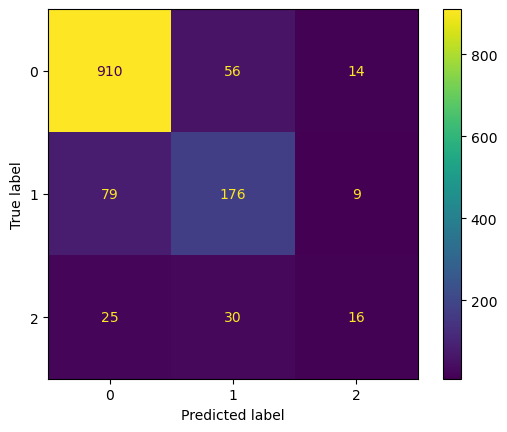

In [645]:
plot_confusion_matrix(lr_gb_model, X_test, y_test)
y_pred = lr_gb_model.predict(X_test)
print(classification_report(y_test, y_pred))

Stacked tuned model is clearly the best so far. Minimal overfitting and the best validation score yet. Try running a version with higher scoring tree to see if it drags the score up without hurting the fit 

In [637]:
estimators_2 = [('lr', sm_model),
             ('gb', best_gb_model)]

sr = StackingClassifier(estimators_2)

lr_gb_model_2 = sr.fit(X_train, y_train)
print(cross_validation(X_train, y_train, lr_gb_model_2))

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

KeyboardInterrupt: 

Bringing in the max trees model reintroduces the overfitting, stick with the reduced depth version

In [646]:
estimators_3 = [('lr', sm_model),
             ('gb', best_gb_model_overfit),
               ('quad', quad_model)]

sr = StackingClassifier(estimators_3)

lr_gb_quad_model = sr.fit(X_train, y_train)
print(cross_validation(X_train, y_train, lr_gb_quad_model))


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

{'train': 0.9183143219264892, 'validation': 0.8329531051964512}


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but SimpleImputer was fitted without feature names
X has feature names, but SimpleImputer was fitted without feature names
X has feature names, but SimpleImputer was fitted without feature names
X has feature names, but SimpleImputer was fitted without feature names
X has feature names, but SimpleImputer was fitted without feature names
X has feature names, but SimpleImputer was fitted without feature names


              precision    recall  f1-score   support

           0       0.89      0.92      0.91       980
           1       0.67      0.64      0.66       264
           2       0.35      0.27      0.30        71

    accuracy                           0.83      1315
   macro avg       0.64      0.61      0.62      1315
weighted avg       0.82      0.83      0.82      1315



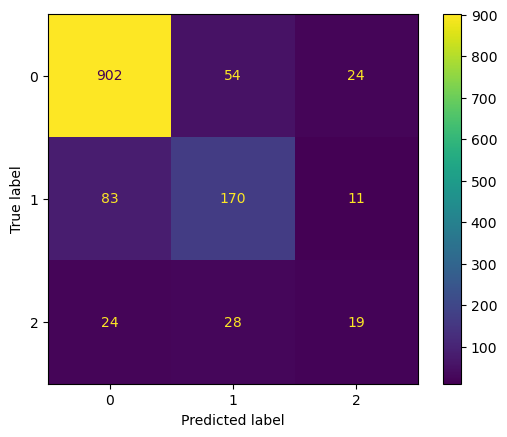

In [647]:
plot_confusion_matrix(lr_gb_quad_model, X_test, y_test)
y_pred = lr_gb_quad_model.predict(X_test)
print(classification_report(y_test, y_pred))

This appears to be the best model so far. Highest validation accuracy score with very little variance. 

## Experiment with Different Scalers 

To experiment with some different scalers, I will run some of the individual models I've run with different scalers to see if there is any improvement.

In [104]:
#baseline with RobustScaler

steps = [('imputer', SimpleImputer(strategy="median")), ('power_scaler', PowerTransformer()),
        ('lr', LogisticRegression(solver = 'saga', random_state=42))]

power_model_pipe = Pipeline(steps)
print(cross_validation(X_train, y_train, power_model_pipe))

/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/qoya/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'train': 0.807107540173053, 'validation': 0.8046971569839307}


In [114]:
quad_model_2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('sampler', SMOTE(sampling_strategy = 'not majority', random_state =42)),
    ('quantile_scaler', QuantileTransformer()),
    ('quad', QuadraticDiscriminantAnalysis())])

quad_model
print(cross_validation(X_train, y_train, quad_model))

{'train': 0.7951174289245981, 'validation': 0.7673671199011125}


The quantile transformer really helped the performance of the quadratic model, could help the stacked version

In [108]:
estimators_4 = [('lr', best_sm_model),
             ('gb', best_gb_model_overfit),
               ('quad', quad_model_2)]

sr = StackingClassifier(estimators_4)

lr_gb_quad_model_2 = sr.fit(X_train, y_train)
print(cross_validation(X_train, y_train, lr_gb_quad_model_2))


{'train': 0.8575401730531521, 'validation': 0.834857849196539}


Very slightly improved results over the original 

### Observations

In the end it seems like StandardScaler is the best for the LogisticRegressions. QuantileTransformer is the best for the quadratic esimator

## Use Feature Importance to Identify Features that can be Removed from the data

In [583]:
# let's try looking at the XGBoost features first
best_gb_pipe_overfit = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('sampler', SMOTE(sampling_strategy = 'not majority', random_state =42)),
    ('std_scaler', StandardScaler()),
    ('gb', XGBClassifier(max_depth = 2, n_estimators = 500, learning_rate = 0.07, subsample = .75, 
                         random_state = 42, ))])

best_gb_pipe_overfit.fit(X_train, y_train)
feat_imp = pd.Series(best_gb_model_overfit.named_steps['gb'].feature_importances_,
             index = X_train.columns).sort_values(ascending = False)

In [585]:
type(feat_imp)

pandas.core.series.Series

[Text(0, 0, 'Area'),
 Text(1, 0, 'Mobile Homes'),
 Text(2, 0, 'Poverty'),
 Text(3, 0, 'Low English'),
 Text(4, 0, 'Crowded Home')]

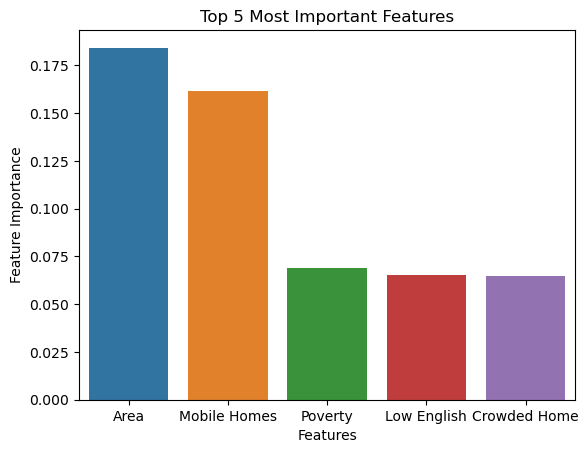

In [593]:
top_5 = feat_imp.head()
fig, ax = plt.subplots()
sns.barplot(x = top_5.index, y = top_5.values)
ax.set_xlabel('Features')
ax.set_ylabel('Feature Importance')
ax.set_title('Top 5 Most Important Features')
new_labels = ['Area', 'Mobile Homes', 'Poverty','Low English', 'Crowded Home']
ax.set_xticklabels(new_labels);


In [651]:
feat_imp

AREA_SQMI    0.184260
E_MOBILE     0.161568
E_POV150     0.069153
E_LIMENG     0.065267
E_CROWD      0.064989
E_MINRTY     0.061070
E_MUNIT      0.041136
E_GROUPQ     0.036327
E_NOHSDP     0.030471
E_UNINSUR    0.030405
E_NOINT      0.029235
E_SNGPNT     0.027824
E_NOVEH      0.027567
E_HU         0.026476
E_HH         0.025835
E_AGE65      0.024858
E_AGE17      0.023291
E_DISABL     0.020789
E_TOTPOP     0.020586
E_HBURD      0.016277
E_UNEMP      0.012616
dtype: float32

Based on the feature importance list, it looks like the top 5 features carry the majority of the weight in the model. The bottom five features are all multicollinear so it would be worth seeing if removing them improves the model's performance. We'll start with the baseline model.

In [652]:
joint_df_2 = joint_df.drop(columns = ['E_HBURD', 'E_UNEMP', 'E_TOTPOP', 'E_DISABL', 'E_AGE17'])

In [653]:
X_2 = joint_df_2.drop(columns = 'target')
y_2 = joint_df_2['target']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, stratify = y, test_size = .25, random_state = 42) 

In [654]:
#Use basline model pipeline
steps = [('imputer', SimpleImputer(strategy="median")), ('std_scaler', StandardScaler()),
        ('lr', LogisticRegression(solver = 'saga', random_state=42))]

model_pipe = Pipeline(steps)
model_pipe

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('std_scaler', StandardScaler()),
                ('lr', LogisticRegression(random_state=42, solver='saga'))])

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but SimpleImputer was fitted without feature names
X has feature names, but SimpleImputer was fitted without feature names


{'train': 0.8014575411913816, 'validation': 0.7979721166032954}
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       980
           1       0.64      0.52      0.57       264
           2       0.50      0.15      0.24        71

    accuracy                           0.81      1315
   macro avg       0.67      0.54      0.57      1315
weighted avg       0.79      0.81      0.79      1315



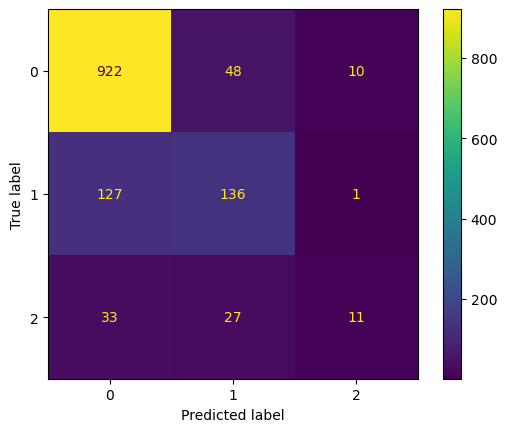

In [655]:
print(cross_validation(X_train_2, y_train_2, model_pipe))
plot_confusion_matrix(model_pipe, X_test_2, y_test_2)
y_pred = model_pipe.predict(X_test_2)
print(classification_report(y_test_2, y_pred))

Negative impact on the baseline. Try the tuned and SMOTED logreg

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but SimpleImputer was fitted without feature names
X has feature names, but SimpleImputer was fitted without feature names


{'train': 0.7229404309252219, 'validation': 0.7214195183776934}
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       980
           1       0.76      0.20      0.31       264
           2       0.18      0.80      0.29        71

    accuracy                           0.73      1315
   macro avg       0.62      0.62      0.50      1315
weighted avg       0.84      0.73      0.74      1315



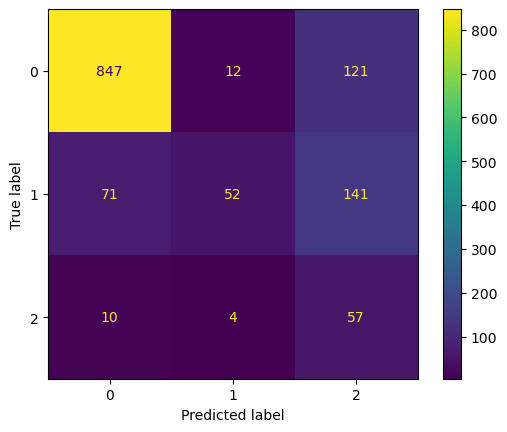

In [656]:
sm_model.fit(X_train_2, y_train_2)
print(cross_validation(X_train_2, y_train_2, sm_model))
plot_confusion_matrix(sm_model, X_test_2, y_test_2)
y_pred = sm_model.predict(X_test_2)
print(classification_report(y_test_2, y_pred))

Still pretty bad, try XGB

{'train': 0.9996291718170582, 'validation': 0.7960444993819531}
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1010
           1       0.56      0.64      0.59       267
           2       0.24      0.32      0.27        72

    accuracy                           0.79      1349
   macro avg       0.57      0.61      0.59      1349
weighted avg       0.81      0.79      0.80      1349



Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but SimpleImputer was fitted without feature names
X has feature names, but SimpleImputer was fitted without feature names


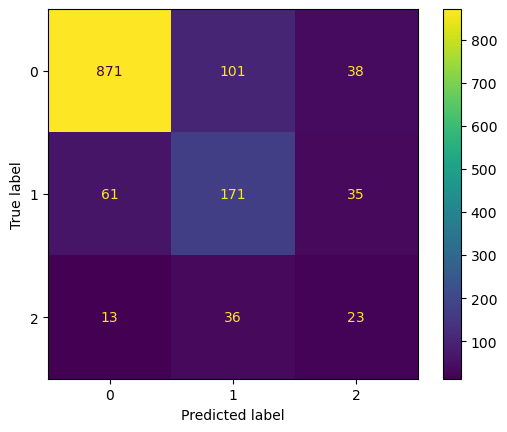

In [147]:
print(cross_validation(X_train_2, y_train_2, gb_model))
plot_confusion_matrix(gb_model, X_test_2, y_test_2)
y_pred = gb_model.predict(X_test_2)
print(classification_report(y_test_2, y_pred))

In [488]:
X_train.columns

Index(['AREA_SQMI', 'E_TOTPOP', 'E_HU', 'E_HH', 'E_POV150', 'E_UNEMP',
       'E_HBURD', 'E_NOHSDP', 'E_UNINSUR', 'E_AGE65', 'E_AGE17', 'E_DISABL',
       'E_SNGPNT', 'E_LIMENG', 'E_MINRTY', 'E_MUNIT', 'E_MOBILE', 'E_CROWD',
       'E_NOVEH', 'E_GROUPQ', 'E_NOINT'],
      dtype='object')

X has feature names, but SimpleImputer was fitted without feature names
X has feature names, but SimpleImputer was fitted without feature names
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.


`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distpl

this be the score argggg 0.7482889733840304


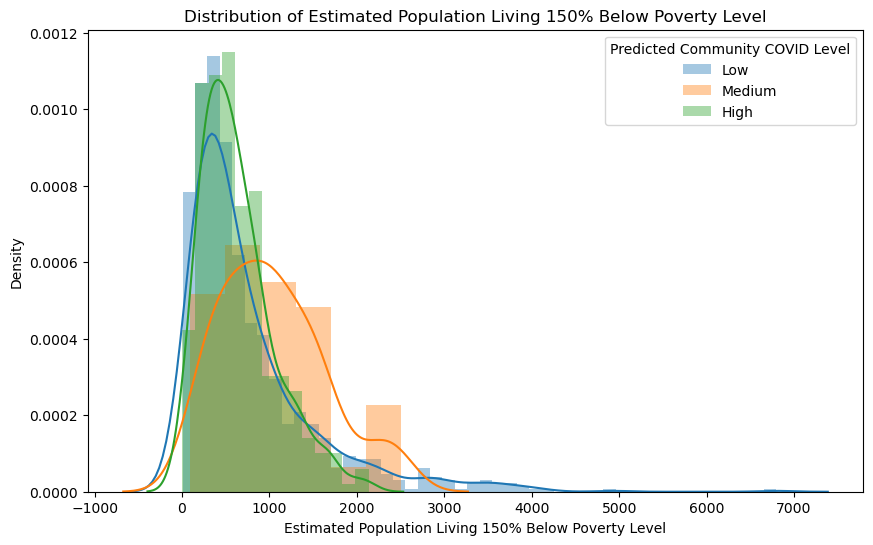

In [640]:
## brendo 

best_sm_model.fit(X_train,y_train)
print('this be the score argggg {}'.format(sm_model.score(X_test,y_test)))

preds = sm_model.predict(X_test)

brendo = pd.concat([X_test.reset_index(), pd.Series(preds)],1)


brendo['preds'] = preds

low = brendo.loc[brendo['preds'] == 0]
medium = brendo.loc[brendo['preds'] == 1]
high = brendo.loc[brendo['preds'] == 2]

fig, ax  = plt.subplots(figsize = (10,6))
sns.distplot(low['E_POV150'], label = 'Low')
sns.distplot(medium['E_POV150'], label = 'Medium')
sns.distplot(high['E_POV150'], label = 'High')
ax.set_xlabel('Estimated Population Living 150% Below Poverty Level')
ax.set_title('Distribution of Estimated Population Living 150% Below Poverty Level')
ax.legend(title = "Predicted Community COVID Level")
fig.show()




In [658]:
from scipy import stats

result = stats.f_oneway(low['E_POV150'], medium['E_POV150'], high['E_POV150']) 
f_stat, p = result
result

F_onewayResult(statistic=11.859204794438117, pvalue=7.863460595807406e-06)

In [659]:
result = stats.f_oneway(low['E_POV150'], medium['E_POV150'], high['E_POV150']) 
f_stat, p = result

if p < .05:
    print('The mean populations living in poverty for each COVID Level group are meaningfully different at the 95% confidence level')
else:
    print('The mean populations living in poverty for each COVID Level group are not meaningfully different')

The mean populations living in poverty for each COVID Level group are meaningfully different at the 95% confidence level


In [660]:
from scipy.stats import ttest_ind

t_stat1, p_value1 = stats.ttest_ind(low['E_POV150'], medium['E_POV150'], equal_var = False)
t_stat1, p_value1

(-3.6790001268808274, 0.00038319022827569804)

In [661]:
t_stat2, p_value2 = stats.ttest_ind(low['E_POV150'], high['E_POV150'], equal_var = False)
t_stat2, p_value2

(3.948534090142988, 8.394552891189018e-05)

In [663]:
if p_value1 and p_value2 < .05:
    print('The mean populations living in poverty for each COVID Level group are meaningfully different at the 95% confidence level')
else:
    print('The mean populations living in poverty for each COVID Level group are not meaningfully different')

The mean populations living in poverty for each COVID Level group are meaningfully different at the 95% confidence level


[Text(0, 0, 'Low'), Text(1, 0, 'Medium'), Text(2, 0, 'Hihg')]

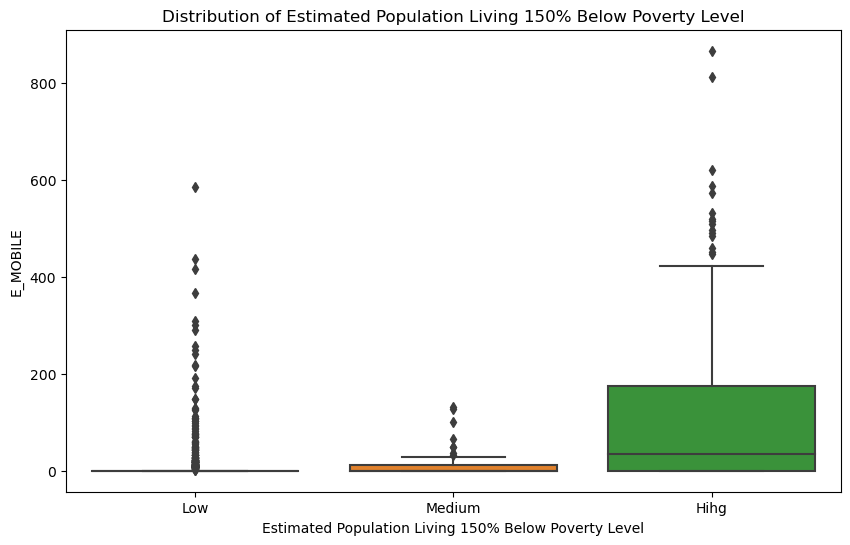

In [673]:
fig, ax  = plt.subplots(figsize = (10,6))
sns.boxplot(x = 'preds', y = 'E_MOBILE', data = brendo)
ax.set_xlabel('Estimated Population Living 150% Below Poverty Level')
ax.set_title('Distribution of Estimated Population Living 150% Below Poverty Level')
ax.set_xticklabels(['Low', 'Medium', 'Hihg'])
# fig.show()



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating you

<Axes: xlabel='E_POV150', ylabel='Density'>

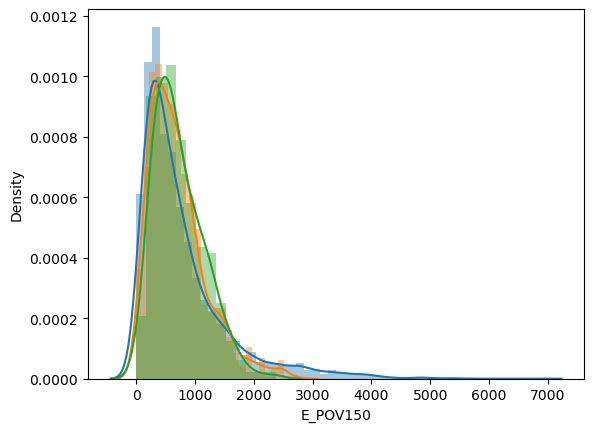

In [520]:
sns.distplot(joint_df['E_POV150'].loc[joint_df['target'] == 0], kde = True)
sns.distplot(joint_df['E_POV150'].loc[joint_df['target'] == 1], kde = True)
sns.distplot(joint_df['E_POV150'].loc[joint_df['target'] == 2], kde = True)

In [148]:
X_train_2.columns

Index(['AREA_SQMI', 'E_TOTPOP', 'E_HU', 'E_POV150', 'E_NOHSDP', 'E_UNINSUR',
       'E_AGE65', 'E_AGE17', 'E_SNGPNT', 'E_LIMENG', 'E_MINRTY', 'E_MUNIT',
       'E_MOBILE', 'E_CROWD', 'E_GROUPQ', 'E_NOINT'],
      dtype='object')

In [149]:
y_train.value_counts()

0    3027
1     801
2     217
Name: target, dtype: int64

## EDA for Visuals

In [470]:
feat_list = list(feat_imp.index)
top_10_feat = feat_imp.head(10)
top_10_feat_list = list(top_10_feat.index)

highly_correlated_features = {}

for feat in top_10_feat_list:
    for index in range(0,len(feat_list)):
        corr = joint_df[feat].corr(joint_df[feat_list[index]])
        if abs(corr) > .5:
            highly_correlated_features[feat] = feat_list[index]
        else:
            pass
    

slim_highly_correlated_features = {key: value for key, value in highly_correlated_features.items() if key != value}
slim_highly_correlated_features
    
    

{'AREA_SQMI': 'E_MOBILE',
 'E_POV150': 'E_UNEMP',
 'E_LIMENG': 'E_HBURD',
 'E_CROWD': 'E_HBURD',
 'E_MINRTY': 'E_UNEMP',
 'E_MUNIT': 'E_HBURD',
 'E_NOHSDP': 'E_UNEMP',
 'E_UNINSUR': 'E_HBURD'}

0.5197374690403038

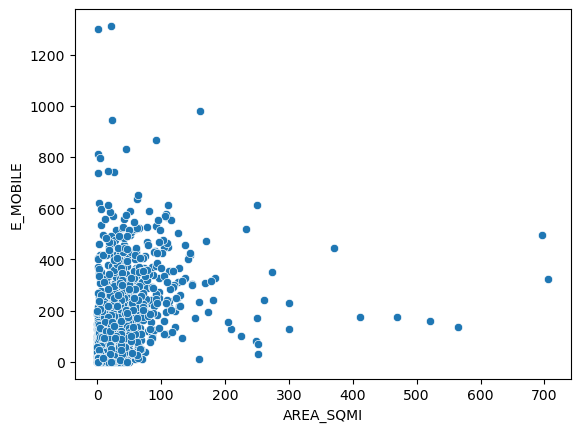

In [463]:
fig, ax = plt.subplots()
sns.scatterplot(x = 'AREA_SQMI', y = 'E_MOBILE', data = joint_df )
joint_df['AREA_SQMI'].corr(joint_df['E_MOBILE'])

0.5481732478430295

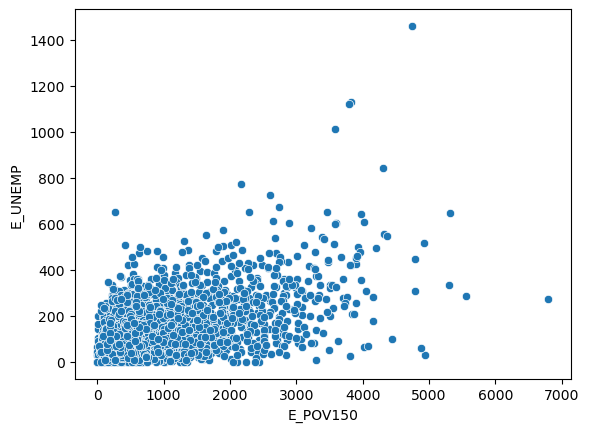

In [471]:
fig, ax = plt.subplots()
sns.scatterplot(x = 'E_POV150', y = 'E_UNEMP', data = joint_df )
joint_df['E_POV150'].corr(joint_df['E_UNEMP'])

0.5745916651790166

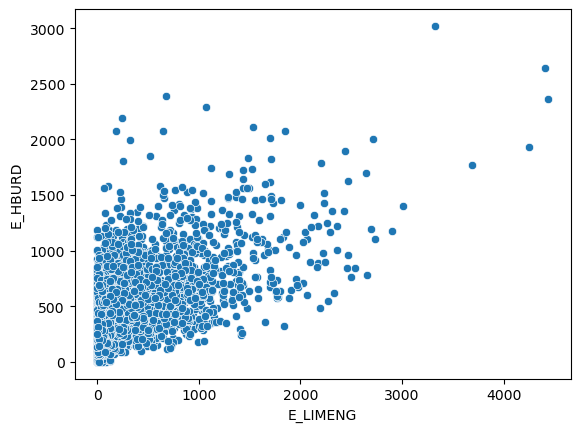

In [472]:
fig, ax = plt.subplots()
sns.scatterplot(x = 'E_LIMENG', y = 'E_HBURD', data = joint_df )
joint_df['E_LIMENG'].corr(joint_df['E_HBURD'])

0.62648801436549

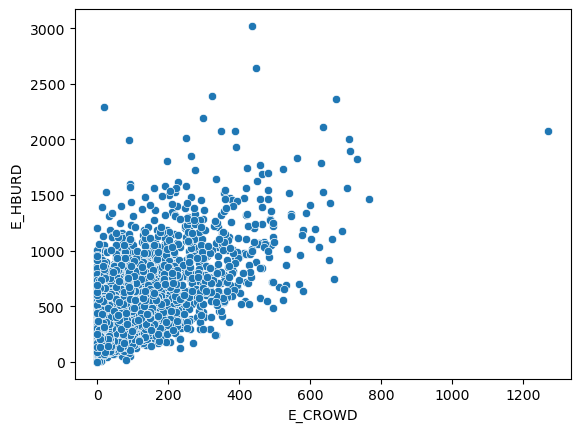

In [473]:
fig, ax = plt.subplots()
sns.scatterplot(x = 'E_CROWD', y = 'E_HBURD', data = joint_df )
joint_df['E_CROWD'].corr(joint_df['E_HBURD'])

0.5823240786792454

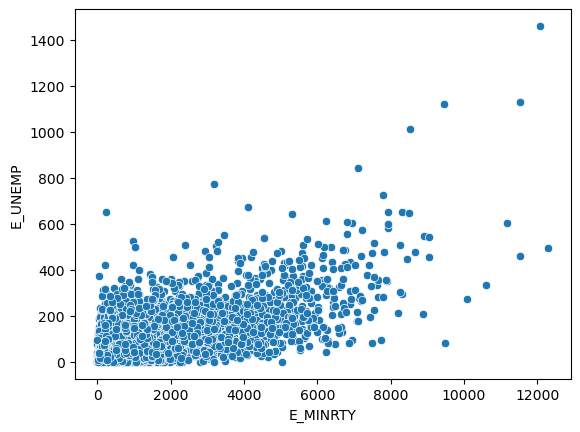

In [474]:
fig, ax = plt.subplots()
sns.scatterplot(x = 'E_MINRTY', y = 'E_UNEMP', data = joint_df )
joint_df['E_MINRTY'].corr(joint_df['E_UNEMP'])

0.6542492051834615

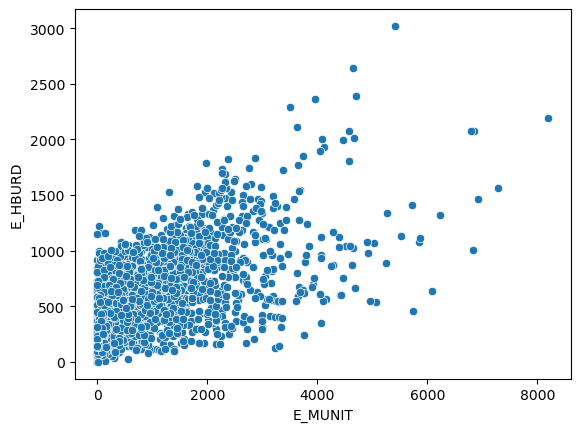

In [475]:
fig, ax = plt.subplots()
sns.scatterplot(x = 'E_MUNIT', y = 'E_HBURD', data = joint_df )
joint_df['E_MUNIT'].corr(joint_df['E_HBURD'])

0.5209883534287917

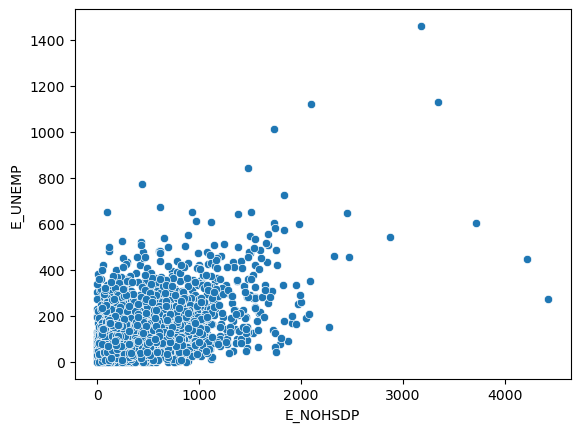

In [476]:
fig, ax = plt.subplots()
sns.scatterplot(x = 'E_NOHSDP', y = 'E_UNEMP', data = joint_df )
joint_df['E_NOHSDP'].corr(joint_df['E_UNEMP'])

0.5203412198300702

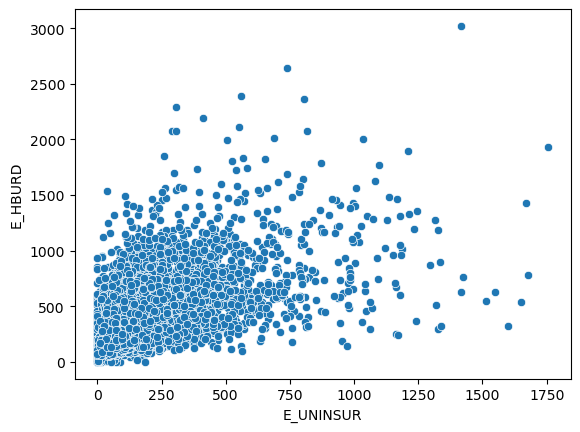

In [477]:
fig, ax = plt.subplots()
sns.scatterplot(x = 'E_UNINSUR', y = 'E_HBURD', data = joint_df )
joint_df['E_UNINSUR'].corr(joint_df['E_HBURD'])